In [141]:
import sympy as sp
import numpy as np
from scipy.integrate import odeint
from matplotlib.pyplot import *
import math
import control as ctr

## EX. 1: Inverted Pendulum

The system in this example consists of an inverted pendulum mounted to a motorized cart. The inverted pendulum system is an example commonly found in control system textbooks and research literature. Its popularity derives in part from the fact that it is unstable without control, that is, the pendulum will simply fall over if the cart isn't moved to balance it. Additionally, the dynamics of the system are nonlinear. The objective of the control system is to balance the inverted pendulum by applying a force to the cart that the pendulum is attached to. A real-world example that relates directly to this inverted pendulum system is the attitude control of a booster rocket at takeoff.

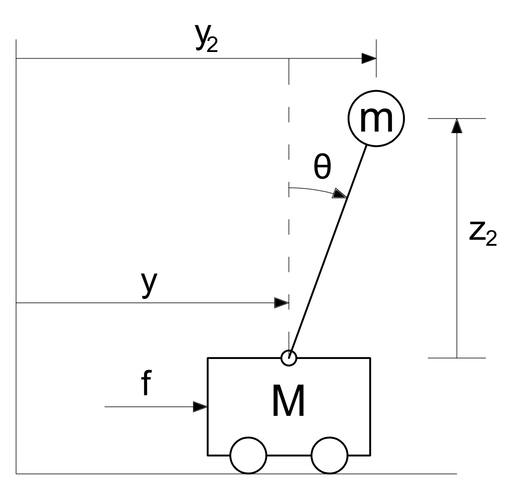

Let us consider the system with the following system parameters
    
    (M)       mass of the cart                         0.5 kg
    
    (m)       mass of the pendulum                     0.2 kg
    
    (l)       length to pendulum center of mass        0.3 m
    
    (b)       coefficient of friction for cart         0.1 N/m/sec
    
    (I)       mass moment of inertia of the pendulum   0.006 kg.m^2
    
    (F)       force applied to the cart
    
    (y)       cart position coordinate
    
    (theta)   angle between the pendulum and the vertical axis

## TODO

Inverted pendulum on the cart can be modeled as follows

$$(M+m)\ddot{y} + b\dot{y} + ml\ddot{\theta}\cos\theta -ml\dot\theta^2\sin(\theta) = F$$

$$ml\cos(\theta)\ddot{y} + (I+ml^2)\ddot{\theta} - mgl\sin\theta = 0$$    

Let $y_1 = \dot{y}$ and $\theta_1 = \dot{\theta}$

1) Show that linearalised model have the following form

$$\dot x = Ax + Bu$$

where state vector $x = (y,y_1,\theta,\theta_1)$, control vector $u=F$. 

$$\left[\begin{array}{c}\dot{y} \\ \dot{y1} \\ \dot{\theta} \\ \dot{\theta_1}\end{array}\right]=
\left[\begin{array}{cccc}0 & 1 & 0 & 0 \\
0 & \frac{-\left(I+m l^2\right) b}{I(M+m)+M m l^2}& \frac{-g m^2 l^2}{I(M+m)+M m l^2} & 0 \\
0 & 0 & 0 & 1 \\
0 & \frac{m l b}{I(M+m)+M m l^2} & \frac{m g l(M+m)}{I(M+m)+M m l^2} & 0\end{array}\right]
\left[\begin{array}{c}y \\ y_1\\ \theta \\ \theta_1\end{array}\right]+
\left[\begin{array}{c}0 \\ \frac{I+m l^2}{I(M+m)+M m l^2} \\ 0\\ \frac{-m l}{I(M+m)+M m l^2}\end{array}\right] u$$


## Let us design a controller such $\lim_{t->+\infty}\theta - 1 = 0$ and $\lim_{t->+\infty}y = 0.$

2) Check for the code below, which design a PID controller to ensure that angular velocity tracks a refence input equal to 1 rad. Is it a good controller to achive desirable behavior of the system?

3) Design state feedback controller for a given specification:
    
    3.1 Is the system controllable. Why is it important?
    
    3.2 Place arbitraty eignvalues in the system to stabilize it. 

    3.2 Use LQR regulator to stabilize the system around zero. Analyze how the different choice of weight matrices Q and R affects the closed-loop system behavior.
    
    The fucntions control.matlab.place and control.lqr from control library 
    https://python-control.readthedocs.io/en/0.9.4/
    
    might be useful for you.
    
    3.3 Add integral term to ensure that angular velocity tracks a refence input equal to 1 rad with zero steady-state error.


In [147]:
# Answer to EX1 q1 using symbolic calculs
# Define symbolic variables
M, m, b, l, I, g, F = sp.symbols('M m b l I g F')
y, y1, theta, theta1, doty1, dottheta1 = sp.symbols('y y1 theta theta1 doty1 dottheta1')

# Define the differential equations of the system
eq1 = (M+m)*doty1 + b*y1 + m*l*dottheta1*sp.cos(theta) - m*l*theta1**2*sp.sin(theta) - F
eq2 = m*l*sp.cos(theta)*doty1 + (I+m*l**2)*dottheta1 - m*g*l*sp.sin(theta)

# Solve for the first derivative of theta1 (angular velocity)
dottheta1_sol = sp.solve(eq2, dottheta1)[0]

# Solve for the first derivative of y1 (linear velocity)
doty1_sol = sp.simplify(sp.solve(eq1.subs(dottheta1, dottheta1_sol), doty1)[0])
dottheta1_sol = sp.simplify(dottheta1_sol.subs(doty1,doty1_sol))

# Define the state-space representation of the system dynamics
f1 = y1
f2 = doty1_sol 
f3 = theta1
f4 = dottheta1_sol
f = sp.Matrix([f1, f2, f3, f4])

# Define state and control variables
variables_x = sp.Matrix([y,y1,theta,theta1])
variables_u = sp.Matrix([F])

# Compute the Jacobian matrices of the system
jacobian_A = sp.simplify(f.jacobian(variables_x).subs([(theta,0), (theta1,0)]))
jacobian_B = sp.simplify(f.jacobian(variables_u).subs([(theta,0), (theta1,0)]))

In [102]:
jacobian_A

Matrix([
[0,                                      1,                                    0, 0],
[0, -b*(I + l**2*m)/(I*M + I*m + M*l**2*m),  -g*l**2*m**2/(I*M + I*m + M*l**2*m), 0],
[0,                                      0,                                    0, 1],
[0,           b*l*m/(I*M + I*m + M*l**2*m), g*l*m*(M + m)/(I*M + I*m + M*l**2*m), 0]])

In [101]:
jacobian_B 

Matrix([
[                                  0],
[(I + l**2*m)/(I*M + I*m + M*l**2*m)],
[                                  0],
[        -l*m/(I*M + I*m + M*l**2*m)]])

In [117]:
def StateSpace(x, t, A, B, u):
    n = A.shape[0]
    B.reshape(n,1)
    return np.dot(A,x) + np.dot(B,[u])

Text(0, 0.5, 'Position ')

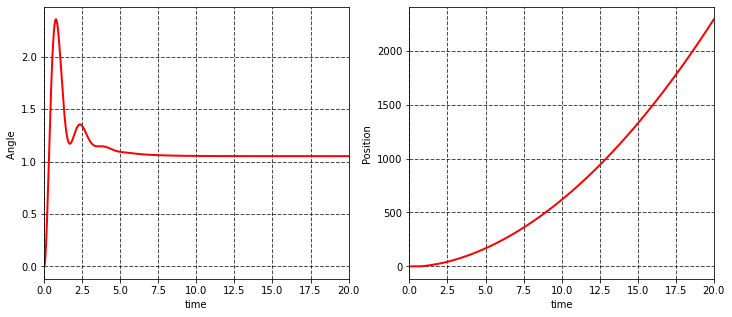

In [150]:
#PID controller
def StateSpacePID_ode(x, t, A, B, C, u, y_ref, k_p, k_i, k_d):
    state = x[:-1]
    y = np.dot(C, state)
    er = y_ref - y
    d_int_e = er
    u_pid = k_p * er + k_i * x[-1] - k_d * np.dot(C, np.dot(A, state))
    dstate = StateSpace(state, t, A, B, u_pid)
    return np.concatenate((dstate, np.array([d_int_e])))

def StateSpacePID(x0, t, A, B, C, u, y_ref, k_p, k_i, k_d):
    x0_ext = np.concatenate((x0, [0])) # add aditional variable for integral term
    solution = odeint(StateSpacePID_ode, x0_ext, t, args=(MatA, MatB, MatC, F, 1, k_p, k_i, k_d))
    return solution

A = np.array(jacobian_A.subs({M:2.5, m:0.2, b:0.1,l:0.7, I:0.006, g:9.81}).evalf()).astype(float)
B = np.array(jacobian_B.subs({M:2.5, m:0.2, b:0.1,l:0.7, I:0.006, g:9.81}).evalf()).astype(float).reshape(4,1)
C = np.array([[1,0,0,0],[0,0,1,0]]) 
D = np.array([0])

x0 = np.array([0,
               0,
               0,
               0])  # initial state

MatC = [0,0,1,0] # Let us assume that we measure only theta
y_ref = 1 # and we want to track constant reference equal to 1 rad. The latter correspond a state responce if the system

k_p = -60;
k_i = -20;
k_d = -6;

t0 = 0 # Initial time 
tf = 20 # Final time
t = np.linspace(t0, tf, 1000) 

solution = StateSpacePID(x0, t, MatA, MatB, MatC, F, 1, k_p, k_i, k_d)

figure(figsize=(12, 5))

y = solution[:,2]

subplot(1, 2, 1)
plot(t, y, linewidth=2.0, color = 'red')
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlabel('time')
xlim([t0, tf])
ylabel(r'Angle ')

y = solution[:,0]
subplot(1, 2, 2)
plot(t, y, linewidth=2.0, color = 'red')
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([t0, tf])
xlabel('time')
ylabel(r'Position ')



## EX 2:  Mass-spring damper system

Let us consider mass-spring damper system

![TP1_SDSystem.png](attachment:TP1_SDSystem.png)

with the following system parameters:

      mass  m = 1.0 kg

      spring constant k = 5.0 N/m

      damping constant $\rho$ = 2 Ns/m

Let us suppose that measured output of the system is a position of the mass.

## TODO

Design a state feedback controller which satisfies the following time domain specifications for a step response ($y_{ref}(t) = 1, t>0$ $y_{ref}(t) = 0, t<0$)

    Rise time < 5 s
    
    Overshoot < 10%
    
    Steady-state error < 2%
    
1) Is system controllable?    
    
2) Choose eigenvalues which ensure the disered behavior of closed-loop system

3) Place them

4) Add integral term, if needed

Remark: if you want to avoid manual tuning (for chosing eigenvalues) you might read this additional material about time domain perfomance of second order system (which is our system)
https://www.tutorialspoint.com/control_systems/control_systems_time_domain_specifications.htm